# 因果フォレスト（Causal Forests）をPythonで実践的に学ぶ（その３） 実践！因果フォレストを用いたデータ分析

url: https://www.salesanalytics.co.jp/datascience/datascience187/

    データ駆動の時代において、因果関係の把握はビジネス意思決定の鍵となります。

    現代のデータサイエンスの中で、「何が原因で何が結果か？」という問いに答えるための技術が日々進化しています。

    前回は、因果フォレストを実行するための主要なライブラリー、因果フォレストの1つであるCausalForestDMLによる因果推論と、その中で使われているダブル機械学習のフレームワークを利用したCATE（Conditional Average Treatment Effect）についてお話ししました。

    url: https://www.salesanalytics.co.jp/datascience/datascience186/

    この記事では、実際のデータを用いて因果フォレストの力を体験します。要は、サンプルデータを使い、因果フォレストのモデル構築、そして結果の可視化までの手順を解説します。

    さらに、得られた結果をどのように解釈し、視覚的にどう表現するかまでを網羅的に学びます。あなたのデータサイエンスのスキルを次のレベルへと導く、実践的なガイドをお届けします。

## 前回の復習
### EconMLライブラリーをインストール
    EconMLライブラリーのCausalForestDMLで、因果フォレストを構築していきます。まだ、EconMLライブラリーをインストールされていない方は、Python環境へインストールをお願いします。

    ターミナル（PowerShellやanaconda promptなど）を開き、以下のコマンドを入力します。

In [1]:
pip install econml

### 4種類の変数Y,T,X,Z
    CausalForestDMLは、ダブル機械学習 (Double Machine Learning) の原則に基づいています。
    通常の機械学習のモデルと異なり、Y, T, X, Wの4種類の変数が登場します。

    Y（アウトカム、Outcome）:
    ・アウトカム (Outcome) または従属変数、目的変数とも呼ばれます。
    ・因果関係を知りたい介入の結果としての変数（例: 薬の投与後の患者の回復率、広告キャンペーン後の売上など）。
    ・要は、推定したい因果の「果」です。

    T（トリートメント、Treatment）:
    ・トリートメント (Treatment) または介入、処置変数とも呼ばれます。
    ・2つの状態（介入されたか/されなかったか）または連続的な介入の度合いを示す変数（例: 薬の投与量、広告の予算など）。
    ・要は、推定したい因果の「因」です。

    X（共変量）:
    ・共変量 (Covariates) とも呼ばれる変数群。
    ・トリートメント効果（推定したい因果）の異質性を理解するために使用される変数（例: ユーザーの年齢、地域、性別など）。
    ・これらの変数に基づいて条件付きのトリートメント効果であるCATE（Conditional Average Treatment Effect）を推定します。

    W（制御変数）:
    ・制御変数 (Controls) とも呼ばれる変数群。
    ・アウトカムY とトリートメントT の関係をモデル化する際に、他の潜在的な影響要因を制御するために使用される変数。
    ・トリートメントの割り当てとアウトカムの関係において、混同を引き起こす可能性がある変数を考慮に入れることで、因果関係の推定をより正確にするために使用されます。

    これらの変数を使用して、CausalForestDMLは因果効果を推定し、特にXに基づいてその効果がどのように異なるかを評価します。



## 因果フォレストモデルの構築手順
    DML（Double Machine Learning、ダブル機械学習）による因果フォレストモデルの構築＆分析の手順の流れを解説します。

    データの準備と前処理
    1.データの準備: データセットを読み込み、Y, T, X, Wを設定します。
    2.前処理: データに欠損値や外れ値が含まれている場合、それらを適切に処理します。また、カテゴリカル変数を数値に変換するなどの前処理も行います。

    モデルの設定と構築
    1.モデルの設定: 構築する因果フォレストモデルを設定（トリートメントモデルやアウトカムモデルなど）します。
    2.モデルの構築: 学習データを使用してモデルを学習します。

    簡単な結果の可視化と解釈
    1.因果効果の推定: テストデータを使用して因果効果の推定を行います。
    2.結果の可視化と解釈: 因果の推定結果をグラフなどで可視化し、どの特徴量が因果関係の推定に重要であるかなどのインサイトを得ます。

## サンプルデータで実施
    以下の3つのサンプルデータを使います。

    不動産業: cf_sampledata_1.csv (https://www.salesanalytics.co.jp/yehi)
    製薬業: cf_sampledata_2.csv (https://www.salesanalytics.co.jp/xnlp)
    飲食業: cf_sampledata_3.csv (https://www.salesanalytics.co.jp/q3vf)

    共通して利用するモジュールを読み込みます。

    以下、コードです。

In [2]:
import numpy as np
import pandas as pd

from econml.dml import CausalForestDML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

    基礎ライブラリー:
    ・numpy: 数値計算を行うためのライブラリ。
    ・pandas: データ分析をサポートするライブラリで、データフレームを主要なデータ構造として提供しています。
    
    機械学習と因果推論のライブラリー:
    ・CausalForestDML from econml.dml: econmlライブラリから因果フォレストのDML実装をインポート。
    ・LinearRegression from sklearn.linear_model: scikit-learnライブラリから線形回帰モデルをインポート。
    ・LogisticRegression from sklearn.linear_model: scikit-learnライブラリからロジスティック回帰モデルをインポート。

    非パラメトリック回帰:
    ・KernelReg from statsmodels.nonparametric.kernel_regression: statsmodelsライブラリからカーネル回帰のモデルをインポート。

    プロットのためのライブラリーと設定:
    ・matplotlib.pyplot: データの可視化のためのライブラリ。
    ・plt.style.use('ggplot'): プロットのスタイルを’ggplot’に設定。
    ・plt.rcParams['figure.figsize']: プロットのデフォルトの図のサイズを[12, 9]に設定。

## 事例１
    事例説明
    ・業種: 不動産業
    ・課題: ある都市に新しい公園を開設することが、近隣の家の価格にどのような影響をもたらすかを知りたい。
    ・推論したい因果: 新しい公園の開設と近隣の家の価格との関係

    Y,T,X,W
    ・Y: 家の価格
    ・T: 公園の開設（1 = 公園が開設されている, 0 = 公園が開設されていない）
    ・X: 家から公園までの距離（公園が近いほど価格に大きな影響を与える可能性がある）
    ・W: 家の面積、建築年、地域の平均所得（これらは家の価格や公園の開設の確率に影響を与える可能性がある）

    新しい公園の開設が近隣の家の価格に与える影響を、家から公園までの距離に応じて評価しています。

    では、データセットを読み込みます。

    以下、コードです。

In [3]:
# データセットのロード
df = pd.read_csv("https://www.salesanalytics.co.jp/yehi")

display(df) #確認

,House_Price,Is_Park_Opened,Distance_to_Park,House_Area,Year_Built,Average_Income
0,360290.080492,1,2.744068,105.017033,2008,40149.842780
1,385180.305950,0,3.575947,94.643627,2020,24032.202540
2,329468.964585,1,3.013817,60.289939,2008,21737.611179
3,378124.682277,0,2.724416,102.879130,1981,73571.036967
4,359181.496039,0,2.118274,84.829407,1982,99219.893824
...,...,...,...,...,...,...
4995,340872.676505,0,1.090779,132.567023,2007,48753.051134
4996,390448.842140,1,1.177267,109.572700,2015,84686.048189
4997,407786.862894,1,0.986941,163.764428,1992,45547.429229
4998,393211.462527,0,1.993436,53.568114,1986,72746.100909


    House_Price: 家の価格を示す数値です。Yです。
    Is_Park_Opened: 公園が開かれているかどうかを示すバイナリ変数です（0 = 開かれていない, 1 = 開かれている）。Tです。
    Distance_to_Park: 家から公園までの距離を示す数値です。Xです。
    House_Area: 家の面積を示す数値です。Wです。
    Year_Built: 家が建てられた年を示す数値です。Wです。
    Average_Income: 地域の平均所得を示す数値です。Wです。

    Y,T,X,Wを設定していきます。

    以下、コードです。

In [4]:
# 変数設定
Y_col = "House_Price"
T_col = "Is_Park_Opened"
X_list = ["Distance_to_Park"]
W_list = ["House_Area","Year_Built","Average_Income"]

# データ設定
Y = df[Y_col]
T = df[T_col]
X = df[X_list]
W = df[W_list]

    因果フォレストを学習します。

    以下、コードです

In [5]:
# CausalForestDMLインスタンス生成と学習
model = CausalForestDML(model_y=LinearRegression(),
                        model_t=LogisticRegression(),
                        discrete_treatment=True)

model.fit(Y, T, X=X, W=W)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


    model = CausalForestDML(...): CausalForestDMLのインスタンスを生成し、modelという変数に代入しています。
    model_y=LinearRegression(),: アウトカムYのモデルとして線形回帰を使用します。
    model_t=LogisticRegression(),: トリートメントTのモデルとして、ロジスティック回帰を使用します。
    discrete_treatment=True,: トリートメントTが離散的（例: バイナリやカテゴリ変数）であることを示すフラグです。
    model.fit(Y, T, X=X, W=W): 生成されたmodelを、提供されたデータで学習させます。

    今回は、アウトカムモデルとして線形回帰を、トリートメントモデルとしてロジスティック回帰を用いましたが、別の回帰問題や分類問題の学習器を指定しても問題ありません。
    また、「discrete_treatment=False」とすると、トリートメントモデルに回帰問題の学習器を指定することもできます。

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [6]:
# 距離ごとの因果効果の推定
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)

    結果をプロットします。カーネル回帰を使用して平滑化しています。

    以下、コードです。

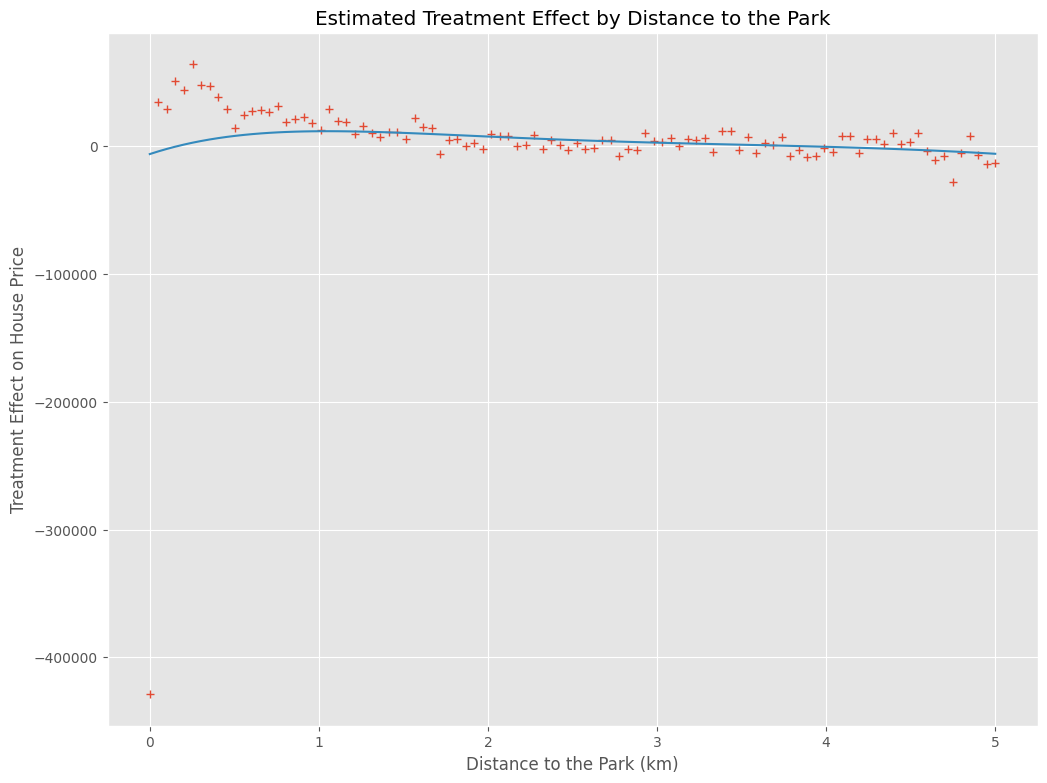

In [7]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[1])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.plot(X_test, y_pred)
plt.xlabel("Distance to the Park (km)")
plt.ylabel("Treatment Effect on House Price")
plt.title("Estimated Treatment Effect by Distance to the Park")
plt.grid(True)
plt.show()

# 公園から500mぐらいまでは効果が高く、3Km以上となるとほぼ効果がないことが分かります。

    kr = KernelReg(treatment_effects, X_test, 'c'):
    ・KernelRegは非パラメトリックなカーネル回帰を実行するためのクラスです。
    ・treatment_effectsは応答変数、X_testは説明変数、'c'は連続型のデータを示すための指定です。
    ・bwはカーネル回帰のバンド幅で値が大きいほど滑らかになります。今回は1としています。
    ・この行では、treatment_effectsとX_testを用いてカーネル回帰のモデルを設定しています。

    y_pred, _ = kr.fit(X_test):
    ・設定されたカーネル回帰モデルを使用して、X_testデータに対する予測を行います。
    ・予測された値はy_predに保存されます。

    plt.plot(X_test, treatment_effects, '+'):
    ・公園までの距離（X_test）に応じた処置効果（treatment_effects）を、+マークでプロットします。

    plt.plot(X_test, y_pred):
    ・公園までの距離（X_test）に応じて、カーネル回帰によって予測された処置効果（y_pred）を線でプロットします。

    plt.xlabel(...), plt.ylabel(...), plt.title(...), plt.grid(True):
    ・グラフのx軸ラベル、y軸ラベル、タイトル、およびグリッドを設定します。

    plt.show():
    ・設定されたプロットを表示します。

## 事例２

    事例説明
    ・業種: 製薬業
    ・課題: 新しい薬の治療効果を評価したい。
    ・推論したい因果: 新しい薬の摂取が患者の健康スコアに与える影響。

    Y,T,X,W
    ・Y: 患者の健康スコア（数値、高いほど健康状態が良い）
    ・T: 新しい薬の摂取（1 = 新しい薬を摂取, 0 = プラセボを摂取）
    ・X: 患者の年齢
    ・W: 患者の性別、基礎疾患の有無、治療開始前の健康スコア

    新しい薬の摂取が患者の健康スコアに与える影響を、患者の年齢に応じて評価しています。

    では、データセットを読み込みます。

    以下、コードです。

In [8]:
# データセットのロード
df = pd.read_csv("https://www.salesanalytics.co.jp/xnlp")

display(df) #確認

,Health_Score,Treatment,Age,Gender,Underlying_Disease,Pre-treatment_Health_Score
0,108.463794,0,64,1,0,87
1,100.183831,0,67,1,0,69
2,109.025367,0,73,1,0,84
3,83.793285,0,20,0,0,68
4,83.643075,0,23,1,0,55
...,...,...,...,...,...,...
4995,100.894809,0,59,1,0,88
4996,110.693951,1,58,0,0,52
4997,105.151079,0,74,0,0,59
4998,105.178232,0,59,0,0,76


    ・Health_Score: 個人の健康スコアを示す数値です。Yです。
    ・Treatment: 処置（おそらくある種の治療や介入）の有無を示すバイナリ変数です（0 = 受けていない, 1 = 受けている）。Tです。
    ・Age: 個人の年齢を示す数値です。Xです。
    ・Gender: 個人の性別を示すバイナリ変数です（0 = 男性, 1 = 女性）。Wです。
    ・Underlying_Disease: 基礎疾患の有無を示すバイナリ変数です（0 = なし, 1 = あり）。Wです。
    ・Pre-treatment_Health_Score: 処置または治療前の健康スコアを示す数値です。Wです。

    Y,T,X,Wを設定していきます。

    以下、コードです。

In [9]:
# 変数設定
Y_col = "Health_Score"
T_col = "Treatment"
X_list = ["Age"]
W_list = ["Gender","Underlying_Disease","Pre-treatment_Health_Score"]

# データ設定
Y = df[Y_col]
T = df[T_col]
X = df[X_list]
W = df[W_list]

    因果フォレストを学習します。

    以下、コードです。

In [10]:
# CausalForestDMLインスタンス生成と学習
model = CausalForestDML(model_y=LinearRegression(),
                        model_t=LogisticRegression(),
                        discrete_treatment=True)

model.fit(Y, T, X=X, W=W)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [11]:
# 年齢ごとの因果効果の推定
X_test = np.linspace(20, 80, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)

    結果をプロットします。カーネル回帰を使用して平滑化しています。

    以下、コードです。

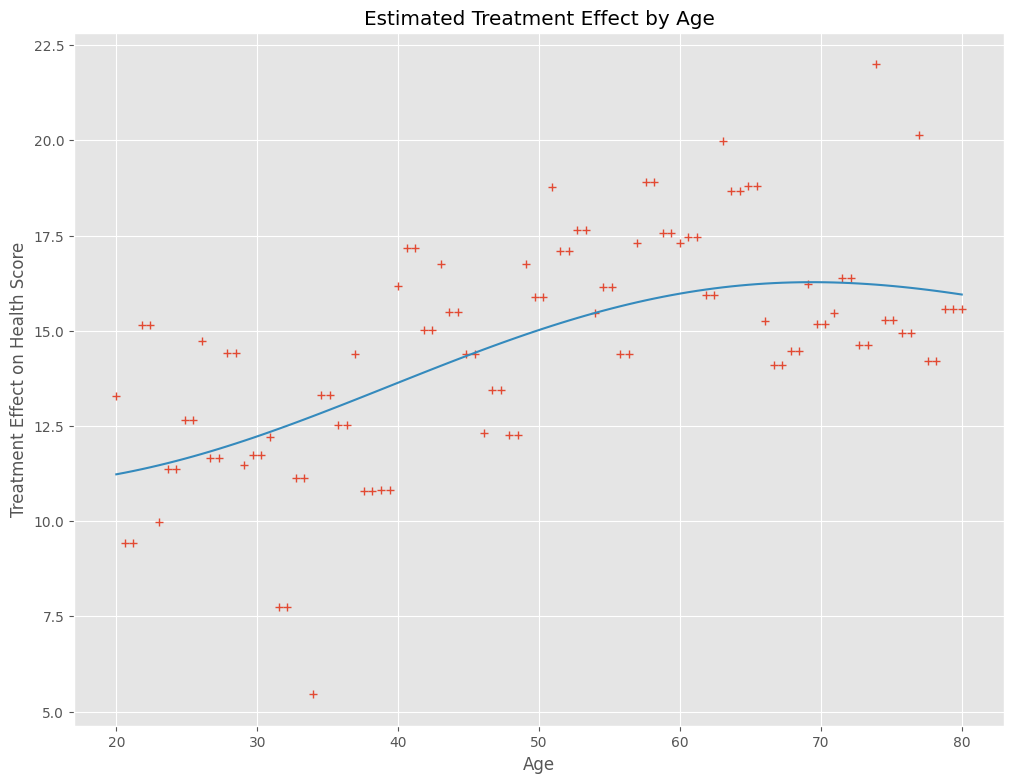

In [12]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[15])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.plot(X_test, y_pred)
plt.xlabel("Age")
plt.ylabel("Treatment Effect on Health Score")
plt.title("Estimated Treatment Effect by Age")
plt.grid(True)
plt.show()

# 年齢が高くなるほど効果が高く、60歳以上はほぼ同じぐらいの効果の高さで落ち着いています。

### 事例３
    事例説明
    ・業種: 飲食業
    ・課題: 最近導入したテーブル上のQRコードオーダーシステムの効果を知りたい。
    ・推論したい因果: QRコードオーダーシステムの導入が、顧客一人あたりの注文金額に与える影響。

    Y,T,X,W
    ・Y: 顧客一人あたりの注文金額
    ・T: QRコードオーダーシステムの導入（1 = 導入済み, 0 = 未導入）
    ・X: 曜日 (0 = 月曜日, 6 = 日曜日)
    ・W: その他の変数、例えば来店時間帯、その日の天気、顧客の年齢層など
    
    QRコードオーダーシステムの導入が、曜日ごとに顧客一人あたりの注文金額に与える影響を評価しています。

    では、データセットを読み込みます。

    以下、コードです。

In [13]:
# データセットのロード
df = pd.read_csv("https://www.salesanalytics.co.jp/q3vf")

display(df) #確認

,Order_Amount,QR_Order_System,Weekday,Visit_Time,Rainfall
0,1250.665588,1,4,0.0,9.511551
1,1203.440545,0,5,2.0,1.466142
2,1018.412486,0,0,2.0,1.666025
3,1129.911909,0,3,1.0,3.968549
4,1142.673558,0,3,0.0,4.235664
...,...,...,...,...,...
4995,1012.537132,0,3,1.0,9.224773
4996,1189.616935,1,2,1.0,5.249401
4997,1208.170323,0,5,2.0,5.364458
4998,1228.232594,0,5,1.0,5.193624


    Order_Amount: 顧客一人あたりの注文金額を示す数値です。Yです。
    QR_Order_System: QRコードオーダーシステムの導入の有無を示すバイナリ変数です（0 = 導入していない, 1 = 導入済み）。Tです。
    Weekday: 曜日を示す数値です。0（月曜日）から6（日曜日）までの整数値を取ります。Xです。
    Visit_Time: 来店時間帯を示す変数です。0（朝）、1（昼）、2（夜）の値を取ります。Wです。
    Rainfall: その日の雨の量を示す数値です。0（晴れ）から上限なし（大雨など）の値を取ります。Wです。

    CausalForestDMLはデフォルトで、のcategories='auto'となっています」。これは」、カテゴリ変数を自動で検出しエンコーディングします。
    この機能によりユーザが事前にカテゴリ変数のエンコーディングを行う必要がなくなります。

    Y,T,X,Wを設定していきます。

    以下、コードです。

In [14]:
# 変数設定
Y_col = "Order_Amount"
T_col = "QR_Order_System"
X_list = ["Weekday"]
W_list = ["Visit_Time","Rainfall"]

# データ設定
Y = df[Y_col]
T = df[T_col]
X = df[X_list]
W = df[W_list]

    因果フォレストを学習します。

    以下、コードです。

In [15]:
# CausalForestDMLインスタンス生成と学習
model = CausalForestDML(model_y=LinearRegression(),
                        model_t=LogisticRegression(),
                        discrete_treatment=True)

model.fit(Y, T, X=X, W=W)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [16]:
# 曜日ごとの因果効果の推定
X_test = np.arange(7).reshape(-1, 1)
treatment_effects = model.effect(X_test)

    結果をプロットします。カーネル回帰を使用して平滑化しています。

    以下、コードです。

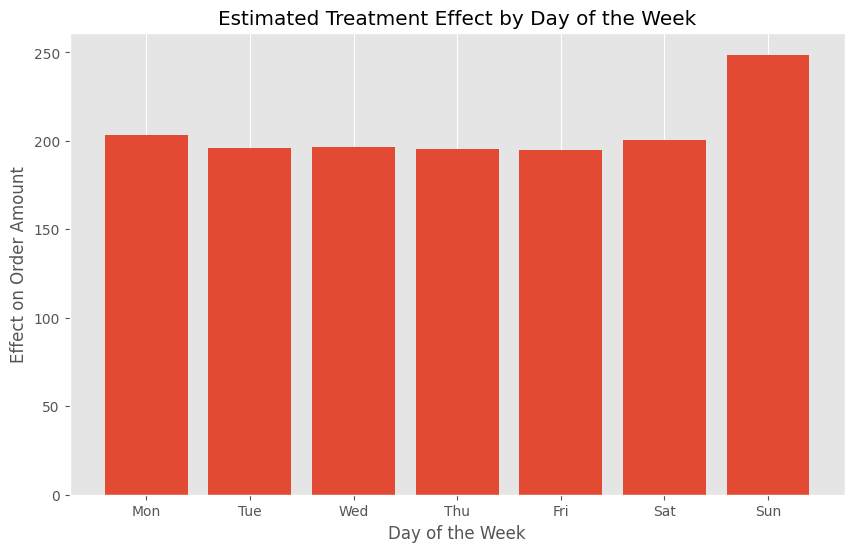

In [17]:
# 結果のプロット
plt.figure(figsize=(10, 6))
plt.bar(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], treatment_effects)
plt.xlabel("Day of the Week")
plt.ylabel("Effect on Order Amount")
plt.title("Estimated Treatment Effect by Day of the Week")
plt.grid(axis='y')
plt.show()

# どの曜日も効果がありますが、特に日曜日に効果が高くなっています。

## まとめ
    本記事では、実際のデータを通じて、因果フォレストの実践的な適用方法を探求しました。

    因果フォレストモデルの構築と、その結果の可視化方法にも触れました。
    こうした知識を基に、因果関係の分析がビジネスや研究にどのように役立つかの理解を深めることができたことでしょう。
    しかし、因果フォレストの学習はここで終わりではありません。

    モデルの性能を最大限に引き出すためのチューニングや最適化が不可欠です。

    次回の「記事4: 因果フォレストのチューニングと最適化」では、モデルのさらなる改善のためのテクニックや方法を学びます。
    ハイパーパラメータの最適な調整方法、バリデーションを通じたモデルの評価、更なる高度なスキルを身につけるためのガイドをお届けします。お楽しみに！